<a href="https://colab.research.google.com/github/Anu0705/Data-Science-Projects-in-Python-R/blob/main/nndl_project(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy
import glob

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array

path = glob.glob("/content/drive/MyDrive/NN DL Project/dataset/train1/*")
imagenames_list = []
image_labels = []
for folder in path:
  for f in glob.glob(folder+"/*.jpg"):
    image_labels.append(folder[-1])
    imagenames_list.append(f)

print(len(imagenames_list))

read_images = []     
i = 0   
for image in imagenames_list:
  i += 1
 
  read_images.append(load_img(image,color_mode='rgb', target_size=(224, 224)))

260


In [ ]:
# prepare x_train and y_train

import tensorflow as tf
image_data = []
for i in range(len(read_images)):
  img_data = tf.keras.utils.img_to_array(read_images[i])
  # img_data = np.expand_dims(img_data, axis = 0)
  img_data = preprocess_input(img_data)

  image_data.append(img_data)

x_train = numpy.asarray(image_data)


y_train = []
for i in range(len(image_labels)):
  y = ord(image_labels[i]) - 65
  y_train.append(y)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=26)

In [ ]:
# # split train and test

# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
# len(x_test)

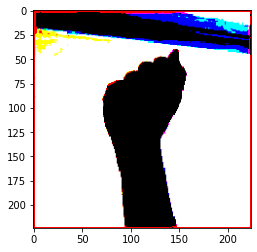

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image_data[0])

In [ ]:
# add additional layers to the base model

CLASSES = 26
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from keras import layers, models

def get_model(base_model):
  
  model = models.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(4096))  
  model.add(layers.Dense(CLASSES, activation='softmax'))

  model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
  
  return model

In [ ]:
# base model VGG1, Trained on ASL, Initialized with ImageNet

IMG_SIZE = (224,224)

base_model_vgg1 = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224,224,3)
)

for layer in base_model_vgg1.layers:
  layer.trainable = True

cascade_model_1a = get_model(base_model_vgg1)

In [ ]:
# cascade_model_1a.layers[0].get_weights()

In [ ]:
cascade_model_1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 26)                106522    
                                                                 
Total params: 117,585,754
Trainable params: 117,585,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cascade_model_1a.fit(x_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
6/6 [==============================] - 20s 1s/step - loss: 45.8506 - accuracy: 0.0423
Epoch 2/10
6/6 [==============================] - 4s 606ms/step - loss: 5.4339 - accuracy: 0.0269
Epoch 3/10
6/6 [==============================] - 4s 598ms/step - loss: 3.2982 - accuracy: 0.0462
Epoch 4/10
6/6 [==============================] - 4s 601ms/step - loss: 3.2679 - accuracy: 0.0385
Epoch 5/10
6/6 [==============================] - 4s 594ms/step - loss: 3.2621 - accuracy: 0.0385
Epoch 6/10
6/6 [==============================] - 4s 598ms/step - loss: 3.2619 - accuracy: 0.0385
Epoch 7/10
6/6 [==============================] - 4s 605ms/step - loss: 3.2683 - accuracy: 0.0385
Epoch 8/10
6/6 [==============================] - 4s 613ms/step - loss: 3.2950 - accuracy: 0.0385
Epoch 9/10
6/6 [==============================] - 4s 603ms/step - loss: 3.2546 - accuracy: 0.0385
Epoch 10/10
6/6 [==============================] - 4s 605ms/step - loss: 3.2317 - accuracy: 0.0577


In [ ]:
# extract weights from all the layers in first model of first cascade

weights_model_1a = []
for layer in cascade_model_1a.layers:
    weights = layer.get_weights()
    weights_model_1a.append(weights)

In [ ]:
# create a copy of the weight matrices from the first model in the first cascade series
weight_list_copy = weights_model_1a

In [ ]:
# train the second model VGG in the cascade with the weights set from the first model VGG
# base model VGG2, Trained on ASL, Initialized with ASL weights

IMG_SIZE = (224,224)

base_model_vgg_1 = VGG16( 
    weights = 'imagenet',
    include_top=False, 
    input_shape=(224,224,3)
)

for layer in base_model_vgg_1.layers:
  layer.trainable = True

## iterate through base model layer names:

layer_count = 0
for layer in base_model_vgg_1.layers:
  if "pool" not in layer.name and "input" not in layer.name:
    weights = weights_model_1a[0].pop(0)
    bias = weights_model_1a[0].pop(0)

    # set weights and biases for base model 1
    base_model_vgg_1.layers[layer_count].set_weights([weights,bias])
  layer_count += 1

cascade_model_1b = get_model(base_model_vgg_1)

In [ ]:
cascade_model_1b.fit(x_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
6/6 [==============================] - 5s 611ms/step - loss: 3.3636 - accuracy: 0.0423
Epoch 2/10
6/6 [==============================] - 4s 614ms/step - loss: 3.3562 - accuracy: 0.0462
Epoch 3/10
6/6 [==============================] - 4s 601ms/step - loss: 3.2620 - accuracy: 0.0385
Epoch 4/10
6/6 [==============================] - 4s 607ms/step - loss: 3.2608 - accuracy: 0.0385
Epoch 5/10
6/6 [==============================] - 4s 606ms/step - loss: 3.2608 - accuracy: 0.0385
Epoch 6/10
6/6 [==============================] - 4s 606ms/step - loss: 3.2605 - accuracy: 0.0385
Epoch 7/10
6/6 [==============================] - 4s 612ms/step - loss: 3.2608 - accuracy: 0.0346
Epoch 8/10
6/6 [==============================] - 4s 614ms/step - loss: 3.2857 - accuracy: 0.0308
Epoch 9/10
6/6 [==============================] - 4s 615ms/step - loss: 3.5090 - accuracy: 0.0462
Epoch 10/10
6/6 [==============================] - 4s 615ms/step - loss: 3.2757 - accuracy: 0.0346


In [ ]:
## preprocess test data

import cv2
import numpy
import glob

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array

path = glob.glob("/content/drive/MyDrive/NN DL Project/dataset/test1/*")

test_list = []
test_labels = []
for folder in path:
  for f in glob.glob(folder+"/*.JPG"):
    test_labels.append(folder[-1])
    test_list.append(f)

print(len(test_list))

test_images = []     
i = 0   
for image in test_list:
  i += 1
  test_images.append(load_img(image,color_mode='rgb', target_size=(224, 224)))

100


In [ ]:
# prepare x_test and y_test

import tensorflow as tf
test_data = []
for i in range(len(test_images)):
  img_data = tf.keras.utils.img_to_array(read_images[i])
  # img_data = np.expand_dims(img_data, axis = 0)
  img_data = preprocess_input(img_data)

  test_data.append(img_data)

x_test = numpy.asarray(test_data)

y_test = test_labels
# for i in range(len(test_labels)):
#   y = ord(test_labels[i]) - 65
#   y_test.append(y)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
y_pred1 = cascade_model_1b.predict(x_test)

4/4 [==============================] - 1s 172ms/step


In [ ]:
y_pred1_list = []
for i in y_pred1:
  k = max(i)
  y_pred1_list.append(k)

In [ ]:
y_pred1_list

[0.1851749,
 0.17217396,
 0.2089988,
 0.21292609,
 0.39742422,
 0.27436674,
 0.26757908,
 0.21276996,
 0.54312587,
 0.20287111,
 0.35555342,
 0.25564474,
 0.20901963,
 0.3887244,
 0.19350526,
 0.24934381,
 0.1866904,
 0.27161524,
 0.17730357,
 0.25208995,
 0.23090513,
 0.2632667,
 0.15933865,
 0.3047819,
 0.6668704,
 0.1900828,
 0.35628054,
 0.43612736,
 0.2661977,
 0.13915962,
 0.27405858,
 0.39324462,
 0.20072624,
 0.33713907,
 0.38760358,
 0.22154927,
 0.4141524,
 0.25072998,
 0.2521166,
 0.2349138,
 0.1804338,
 0.31387252,
 0.38665113,
 0.30242318,
 0.18443064,
 0.3524338,
 0.15318446,
 0.3637301,
 0.26628974,
 0.12403971,
 0.36944416,
 0.34297755,
 0.37755713,
 0.3289057,
 0.3888664,
 0.39129147,
 0.3203666,
 0.35432285,
 0.4479708,
 0.14078669,
 0.3112028,
 0.26363614,
 0.42418414,
 0.2744469,
 0.27292806,
 0.3523057,
 0.2618,
 0.34952518,
 0.29427308,
 0.30382764,
 0.15624379,
 0.23382296,
 0.19102727,
 0.17275073,
 0.24608453,
 0.16601306,
 0.20223981,
 0.23867592,
 0.18551531,

In [ ]:
# #[[[vgg_values]],[flatten],[Dense],[softmax]]
# len(weights_list[0])  #----> len(VGG)
# len(weights_list[0][0]) # First layer of VGG shape --> (3,3,3,64)  --- > channels R, G, B
# #3 
# len(weights_list[0][0][0]) # First layer of VGG shape --> (3,3,3,64)  --- > channel R, last index if it changes to 1 gives G, if its 2 it gives B

In [ ]:
##### R values #####
# []
# 1st sublist[R] - 1st sublist = first row first column of all 64 filters
# 1st sublist[R] - 2nd sublist = first row, second column of all 64 filters
# 1st sublist[R]  - 3rd sublist = first row ,third column of all 64 filters

In [ ]:
# []
# 2st sublist[R] - 1st sublist = second row first column of all 64 filters
# 2st sublist[R] - 2nd sublist = second row, second column of all 64 filters
# 2st sublist[R]  - 3rd sublist = second row ,third column of all 64 filters

In [ ]:
# []
# 3st sublist[R] - 1st sublist = third row first column of all 64 filters
# 3st sublist[R] - 2nd sublist = third row, second column of all 64 filters
# 3st sublist[R]  - 3rd sublist = third row ,third column of all 64 filters

In [ ]:
# First row of the R channels filters 
# weights_list[0][0][0][0]

In [ ]:
# first sublist is R, second sublist is G and third sublist is B, 
# each sublist within shows 1st row, 2nd row and 3rd row

# weights_1 = weights_list[0][0]
# weights_1

In [ ]:
## model [0][0] - 1st layer weights      ## base_model_1 [0][0] - inputs
## model [0][1] - 1st layer bias         ## base_model_1 [0][1] - 1st layer weights + bias,

## model [0][2] - 2nd layer weights      ## base_model_1 [0][2] - 2nd layer weights + bias, 2,3
## model [0][3] - 2nd layer bias         
                                         ## base_model_1 [0][3] - maxpool

## model [0][4] - 3rd layer weights      ## base_model_1 [0][4] - 3rd layer weights + bias, 4,5
## model [0][5] - 3rd layer bias         

## model [0][6] - 4th layer weights      ## base_model_1 [0][4] - 4th layer weights + bias, 6,7
## model [0][7] - 4th layer bias 

## model [0][8] - 4th layer weights      ## base_model_1 [0][5] - 4th layer weights + bias, 8,9
## model [0][9] - 4th layer bias 

In [ ]:
## base_model [0][0] - 1st layer weights      ## base_model_1 [0][0] - inputs
## base_model [0][1] - 1st layer bias         ## base_model_1 [0][1] - 1st layer weights + bias, 0,1

## base_model [0][2] - 2nd layer weights      ## base_model_1 [0][2] - 2nd layer weights + bias, 2,3
## base_model [0][3] - 2nd layer bias         

## base_model [0][4] - 3rd layer weights      ## base_model_1 [0][3] - 3rd layer weights + bias, 4,5
## base_model [0][5] - 3rd layer bias         

## base_model [0][6] - 4th layer weights      ## base_model_1 [0][4] - 4th layer weights + bias, 6,7
## base_model [0][7] - 4th layer bias 

## base_model [0][8] - 4th layer weights      ## base_model_1 [0][5] - 4th layer weights + bias, 8,9
## base_model [0][9] - 4th layer bias 

In [ ]:
## <<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [ ]:
# test_model = VGG16(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(224,224,3)
# )

In [ ]:
# import numpy as np
# import random
# test_weights = np.random.rand(3,3,3,64)
# test_bias = np.random.rand(64)

In [ ]:
# test_weights

In [ ]:
# test_weights[:,:,:,0]

In [ ]:
# layer = test_model.layers[1]
# t_weights, t_bias = layer.get_weights()

In [ ]:
# test_model.layers[1].set_weights([test_weights,test_bias])

In [ ]:
# layer = test_model.layers[1]
# t1_weights, t1_bias = layer.get_weights()

In [ ]:
# t1_weights[:,:,:,0]